Modularize functions for scaling and labeling so easier to test different configurations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn.preprocessing as preprocess
from collections import Counter
import pprint

pp = pprint.PrettyPrinter(indent=4)

In [2]:
data = pd.read_csv("topCharts_continuous.csv", index_col= 0)

In [3]:
cluster_df0 = pd.DataFrame(columns = data.columns)

for a in data["Artist"].unique():
    df_a = data[data["Artist"] == a]
    for s in df_a["Title"].unique():
        df_as = df_a[df_a["Title"] == s]
        cluster_df0.loc[len(cluster_df0)] = df_as.iloc[0,:]

In [4]:
print(len(cluster_df0))

3442


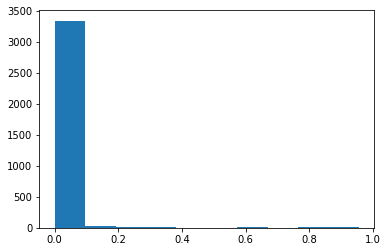

0.6118535735037769

In [6]:
plt.hist(cluster_df0["Instrumentalness"])
plt.show()

len(cluster_df0[cluster_df0["Instrumentalness"] == 0])/len(cluster_df0)

61% of songs have 0 instrumentalness, not contributing much so drop

In [7]:
cluster_df = cluster_df0.drop(columns = ["Instrumentalness", "Acousticness"]) 

In [8]:
def scaleData(scaler, data, firstCol):
    mms = scaler()
    cluster_values = data.iloc[:,firstCol:]
    mms.fit(cluster_values)
    return mms.transform(cluster_values)

In [9]:
data_transformed = scaleData(preprocess.StandardScaler, cluster_df, 2)

In [10]:
print(len(data_transformed))

3442


In [11]:
def plotKMeans(data, minCluster, maxCluster):
    inertias = []
    for i in range(minCluster, maxCluster):
        kmeans = KMeans(n_clusters = i).fit(data)
        inertias.append(kmeans.inertia_)    
    
    plt.plot(range(1,len(inertias)+1), inertias, "bx-")
    plt.xlabel('k')
    plt.ylabel("Inertia")
    plt.xticks(range(1,len(inertias)+1))
    plt.show()
    
    
    diffs = np.array(inertias[1:]) - np.array(inertias[:len(inertias)-1])
    plt.plot(range(1,len(inertias)+1), [-inertias[0]] + list(diffs),"bx-")
    plt.ylabel("Change in Inertia")
    plt.xticks(range(1,len(inertias)+1))

    plt.show()
    
    return(inertias)
    

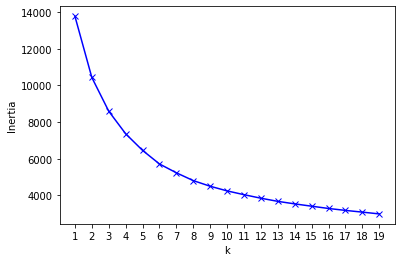

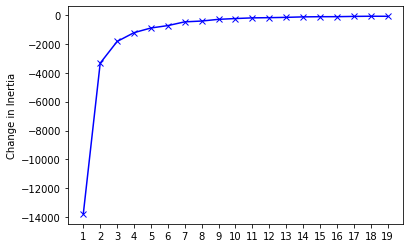

In [12]:
inertias = plotKMeans(data_transformed, 1, 20)

In [13]:
def fitKMeans(data, clusters):
    labels_df = cluster_df.copy()
    kmeans_opt = KMeans(n_clusters = clusters).fit(data)
    labels_df["Label"] = kmeans_opt.labels_
    

    groups ={}
    counters = {}
    for i in range(clusters):
        groups[i] = labels_df[labels_df["Label"] == i]
        counters[i] = Counter(groups[i]["Artist"])
    
    return groups, counters

In [32]:
groups, counters = fitKMeans(data_transformed, 364)

3442


In [33]:
def getClusterSongs(cluster_num, groups, counters, artists = [], n_artists = 3):
    cnt = counters[cluster_num]
    grp = groups[cluster_num]
    artsong = {}
    if artists:
        assert(set(artists).issubset(set(cnt.keys())))
    else:
        n_artists = min(n_artists, len(cnt.keys()))
        artists = [a[0] for a in cnt.most_common(n_artists)]
    for artist in artists:
        artsong[artist] = list(grp[grp["Artist"] == artist]["Title"])
    return artsong   

In [35]:
pp.pprint(getClusterSongs(0, groups, counters, n_artists = 5))

{   'BTS': ['Magic Shop'],
    'Dan + Shay': ['Keeping Score (feat. Kelly Clarkson)'],
    'Future': ['XanaX Damage', 'St. Lucia'],
    'Post Malone': ['Goodbyes (Feat. Young Thug)'],
    'Trippie Redd': ['Fire Starter', 'Signing Off']}


In [36]:
pp.pprint(getClusterSongs(3, groups, counters))

{   'Maroon 5': [   'What Lovers Do (feat. SZA)',
                    'Girls Like You (feat. Cardi B)',
                    'What Lovers Do'],
    'Selena Gomez': ['Dance Again', 'Let Me Get Me'],
    'XXXTENTACION': ['What in XXXTarnation', 'Gassed Up!']}
